<a href="https://colab.research.google.com/github/Carlos-Rodero/kduino_data_analysis_notebook/blob/main/Kduino_Data_Analysis_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mooda===2.0.0

import mooda as md
import pandas as pd
import numpy as np
import glob
import yaml
import os
import re
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
from scipy import stats, interpolate
from io import StringIO
from datetime import datetime
import warnings
from google.colab import files

warnings.simplefilter(action="ignore", category=FutureWarning)

!rm /content/*txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 577.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 654.0/654.0 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.0 MB/s eta 0:00:00
rm: cannot remove '/content/*txt': No such file or directory


<p><img alt="logo" height="150px" src='https://drive.google.com/uc?export=view&id=11Swg70eHalalGMv8HemoK6l7qu3XRuLC' align="center" hspace="10px" vspace="0px"/></p>
<h1><b>KdUINO Data Analysis Notebook</b></h1>

The KdUINO Data Analysis Notebook is a Jupyter Notebook hosted by Google Colab designed to analyze data files from [KdUINO](https://monocle-h2020.eu/Sensors_and_services/KdUINO) instrumentation. Also, provide methods to generate plots and convert data files in netCDF and CSV format.</br>This Notebook works with different versions of KdUINO:
*   KduPRO
*   KduSTICK
*   KduMOD Professional
*   KduMOD Low-Cost
</br>

---

<p><img alt="logo" height="100px" src='https://git.csic.es/36579996Z/kduino-data-analysis/-/raw/master/docs/img_docs/logo.png' align="center" hspace="10px" vspace="0px"/></p>

This project has received funding from the European Union's Horizon 2020 research and innovation programme under grant agreement No 776480 ([MONOCLE](https://monocle-h2020.eu/)).

# Select KdUINO
Please select your KdUINO instrument:

In [2]:
#@title Select KdUINO { run: "auto", display-mode: "form" }
kduino = "KduPRO" #@param ["KduPRO", "KduSTICK", "KduMOD Professional", "KduMOD Low-Cost", "KdUINO"]

# Upload Files

Please upload the files from your KdUINO instrument:

In [3]:
uploaded = files.upload()

Saving 2024-08-09_buoyBuoy01_Spain_Somorrostro_0.70.txt to 2024-08-09_buoyBuoy01_Spain_Somorrostro_0.70.txt
Saving 2024-08-09_buoyBuoy01_Spain_Somorrostro_1.40.txt to 2024-08-09_buoyBuoy01_Spain_Somorrostro_1.40.txt
Saving 2024-08-09_buoyBuoy01_Spain_Somorrostro_2.10.txt to 2024-08-09_buoyBuoy01_Spain_Somorrostro_2.10.txt
Saving 2024-08-09_buoyBuoy01_Spain_Somorrostro_2.80.txt to 2024-08-09_buoyBuoy01_Spain_Somorrostro_2.80.txt
Saving 2024-08-09_buoyBuoy01_Spain_Somorrostro_3.50.txt to 2024-08-09_buoyBuoy01_Spain_Somorrostro_3.50.txt


# Configuration

Please configure the time of the sample.

In [31]:
#@title Configuration start and stop { run: "auto", display-mode: "form" }

date_start = '2024-08-09' #@param {type:"date"}
time_start = '12:30:00' #@param {type:"string"}
date_stop = '2024-08-09' #@param {type:"date"}
time_stop = '13:00:00' #@param {type:"string"}

pre_datetime_start = date_start + "Z" + time_start + "T+00:00"
pre_datetime_stop = date_stop + "Z" + time_stop + "T+00:00"

datetime_start = datetime.fromisoformat(pre_datetime_start)
datetime_stop = datetime.fromisoformat(pre_datetime_stop)

# Set Quality Control parameter $\rho$

Please configure the $\rho$ value as a Quality Control parameter.

**Value between 0.0 and 1.0**.





In [34]:
#@title Select $\rho$ value { run: "auto", display-mode: "form" }
r2_value_input = 0.8 # @param {"type":"number"}


# Analysis

Analysis of the KdUINO instrument.

1.- Analysis and output as .csv file

2.- Plot linear regressions for each minute (in the PAR band)

3.- Plot Kd Red, Green, Blue and PAR with r2 parameter

In [35]:
#@title 1.- Analysis and output as .csv file

def analysis_kduino():
  # Function to analyse data from KdUINO to obtain Kd
  if kduino == 'KduPRO':
    print("Device: KduPRO")
    print(f"Start: {datetime_start}")
    print(f"End:   {datetime_stop}")

    # Definitions for regular expression paterns
    start_string_metadata = r"METADATA"
    stop_string_metadata = r"DATA"
    last_start_string_data = r"\bDATA"
    end_string_data = r'$(?![\r\n])'

    metadata_patron = re.compile(r'{}(?P<length>)\s*(?P<table>[\s\S]*?){}'.format(
        start_string_metadata, stop_string_metadata))
    data_patron = re.compile(r'{}(?P<length>)\s*(?P<table>[\s\S]*?){}'.format(
        last_start_string_data, end_string_data))

    selected_info = ""
    metadata_list = []
    metadata = {}
    data_list = []
    kdupro_list = []

    for k, v in uploaded.items():
      with open(k) as reader:
        content = reader.read()

        # Regular expression to find the metadata patron
        for m in re.finditer(metadata_patron, content):
          selected_info = m.group('table')
          lines = selected_info.splitlines()
          metadata = {}

          for line in lines:
            key = line.split(":")[0]
            if line.count(":") > 1:
              date_splitted = (line.rsplit(":")[-3:])
              date_splitted = " ".join(date_splitted)
              value = date_splitted
              metadata[key] = value
            else:
              try:
                value = line.split(":")[1]
                metadata[key] = value.strip()
              except IndexError as er:
                pass

          metadata_list.append(metadata)

        # Regular expression to find the data patron
        for d in re.finditer(data_patron, content):
          selected_info_data = d.group('table')
          data = StringIO(selected_info_data)

          df = pd.read_csv(data, skipinitialspace=True, skiprows=1, header=None,
                           parse_dates={'TIME': [0]},
                           delimiter=' ', engine='python').set_index('TIME')

          data_list.append(df)

    for index, df in enumerate(data_list):
      if datetime_start in df.index or datetime_stop in df.index:
        kdupro_list.append(index)

    # process the files we have selected
    def create_wf():
      df = data_list[index]
      metadata = metadata_list[index]
      df.columns = range(df.shape[1])

      # Delete unused columns
      if len(df.columns) > 4:
        df_copy = df.copy()
        ncol = len(df.columns)
        x = range(4, ncol)
        df = df.drop(x, axis=1)

      df.columns = range(df.shape[1])

      # Creation of WaterFrame
      wf = md.WaterFrame()

      # Copy metadata to waterframe
      wf.metadata = metadata
      depth = wf.metadata["depth"]

      # Set name of parameters
      param_red = f'RED_{depth}'
      param_green = f'GREEN_{depth}'
      param_blue = f'BLUE_{depth}'
      param_clear = f'CLEAR_{depth}'

      # Set name of QC parameters
      param_red_qc = f'RED_{depth}_QC'
      param_green_qc = f'GREEN_{depth}_QC'
      param_blue_qc = f'BLUE_{depth}_QC'
      param_clear_qc = f'CLEAR_{depth}_QC'

      # Init data of waterframe
      wf.data[param_red] = df[0]
      wf.data[param_green] = df[1]
      wf.data[param_blue] = df[2]
      wf.data[param_clear] = df[3]

      # Create vocabulary
      wf.vocabulary[param_red] = {'units': "counts"}
      wf.vocabulary[param_green] = {'units': "counts"}
      wf.vocabulary[param_blue] = {'units': "counts"}
      wf.vocabulary[param_clear] = {'units': "counts"}

      # Resample to seconds
      wf.resample('s')

      # Delete last index because it is a minute that we are not going to use
      wf.data.drop(wf.data.tail(1).index, inplace=True)

      # Extract data of the dataframe df. Put all counts in the proper column
      red_list = []
      green_list = []
      blue_list = []
      clear_list = []

      for j in range(len(df_copy.index)-1):
        for i in range(len(df_copy.columns)):
          if i % 4 == 0:
            red_list.append(df_copy[i][j])
            green_list.append(df_copy[i+1].iloc[j])
            blue_list.append(df_copy[i+2].iloc[j])
            clear_list.append(df_copy[i+3].iloc[j])
      red_array = np.array(red_list)
      green_array = np.array(green_list)
      blue_array = np.array(blue_list)
      clear_array = np.array(clear_list)

      wf.data[param_red] = red_array
      wf.data[param_green] = green_array
      wf.data[param_blue] = blue_array
      wf.data[param_clear] = clear_array

      # Init waterframe QC data
      wf.data[param_red_qc] = 0
      wf.data[param_green_qc] = 0
      wf.data[param_blue_qc] = 0
      wf.data[param_clear_qc] = 0

      return wf

    def merge_metadata(dict1, dict2):
      # Merge dictionaries
      dict3 = {**dict1, **dict2}
      # Iterate over items in new dictionary
      for key, value in dict3.items():
        # If keys are in both dictionaries
        if key in dict1 and key in dict2:
          # If dictionary contains list of elements
          if isinstance(value, list):
            # If values of new dict and values from parameter dict are different,
            # and not included in the new dict
            if (dict1[key] not in value) and (set(dict1[key]) != set(value)):
              dict3[key].append(dict1[key])
            elif (dict2[key] not in value) and (set(dict2[key]) != set(value)):
              dict3[key].append(dict2[key])

          # If dictionary not contains list of elements
          else:
            if value != dict1[key]:
              dict3[key] = [value, dict1[key]]
            elif value != dict2[key]:
              dict3[key] = [value, dict2[key]]

      return dict3

    wf_list = []
    for index in kdupro_list:
      wf = create_wf()
      wf_list.append(wf)

    # Declare lists
    names = []
    depths = []

    # Create unique waterframe
    wf_all = md.WaterFrame()

    # Concat all waterframes
    for index, wf in enumerate(wf_list):
      if index == 0:
        wf_all = wf.copy()
      else:
        # Concat data
        wf_all.data = pd.concat([wf_all.data, wf.data], axis=1)
        # Add metadata
        wf_all.metadata = merge_metadata(wf.metadata, wf_all.metadata)
        # Add vocabulary
        for param in wf.parameters:
          wf_all.vocabulary[param] = wf.vocabulary[param]

    # Append names and depths to each list
    for wf in wf_list:
      if wf is None:
        pass
      else:
        name = wf.metadata["name"]
        names.append(name)
        depth = wf.metadata["depth"]
        depths.append(depth)

    # Slice time
    mask = (
        wf_all.data.index >= datetime_start) & (
            wf_all.data.index <= datetime_stop)
    wf_all.data = wf_all.data.loc[mask]

    # Resample time
    wf_all.resample("T")

    # Convert depths list elements to float, and save it as a numpy array
    depths = np.array(list(map(float, depths)))

    # Save CLEAR data in one new waterframe
    wf_clear = md.WaterFrame()
    wf_clear.metadata = wf_all.metadata
    wf_clear.vocabulary = wf_all.vocabulary
    match_CLEAR = [s for s in wf_all.data if ("CLEAR_" in s) and ("QC" not in s)]
    wf_clear.data = wf_all.data.filter(match_CLEAR)

    # Create columns Kd and R2
    wf_all.vocabulary = {}
    create_columns_Kd(wf_all)

    # Create lists with parameters name
    match_RED = [s for s in wf_all.data if ("RED_" in s) and ("QC" not in s)]
    match_GREEN = [s for s in wf_all.data if ("GREEN_" in s) and ("QC" not in s)]
    match_BLUE = [s for s in wf_all.data if ("BLUE_" in s) and ("QC" not in s)]

    # Calculate Kd taking into account the R2 coefficient.
    # If data has lower values, R2 and Kd is nan.
    # Iterate over each row of data
    for index, _row in wf_all.data.iterrows():
      # CLEAR
      calculate_kd(
          wf_all, match_CLEAR, index, depths, r2_value_input, column_name_Kd='KD_CLEAR', column_name_R2='R2_CLEAR')
      # RED
      calculate_kd(
          wf_all, match_RED, index, depths, r2_value_input, column_name_Kd='KD_RED', column_name_R2='R2_RED')
      # GREEN
      calculate_kd(
          wf_all, match_GREEN, index, depths, r2_value_input, column_name_Kd='KD_GREEN', column_name_R2='R2_GREEN')
      # BLUE
      calculate_kd(
          wf_all, match_BLUE, index, depths, r2_value_input, column_name_Kd='KD_BLUE', column_name_R2='R2_BLUE')

    avgKd_clear = wf_all.data.loc[wf_all.data['R2_CLEAR'] > r2_value_input, 'KD_CLEAR'].mean()
    print(f"Average Kd PAR for samples with r2 > {r2_value_input} =   {np.around(avgKd_clear, 3):.2f}")

    avgKd_red = wf_all.data.loc[wf_all.data['R2_RED'] > r2_value_input, 'KD_RED'].mean()
    print(f"Average Kd RED for samples with r2 > {r2_value_input} =   {np.around(avgKd_red, 3):.2f}")

    avgKd_green = wf_all.data.loc[wf_all.data['R2_GREEN'] > r2_value_input, 'KD_GREEN'].mean()
    print(f"Average Kd GREEN for samples with r2 > {r2_value_input} = {np.around(avgKd_green, 3):.2f}")

    avgKd_blue = wf_all.data.loc[wf_all.data['R2_BLUE'] > r2_value_input, 'KD_BLUE'].mean()
    print(f"Average Kd BLUE for samples with r2 > {r2_value_input} =  {np.around(avgKd_blue, 3):.2f}")

    # Calculate Kd with all the values
    # Iterate over each row of data
    for index, _row in wf_all.data.iterrows():
      # CLEAR
      calculate_kd(
          wf_all, match_CLEAR, index, depths, 0, column_name_Kd='KD_CLEAR', column_name_R2='R2_CLEAR')
      # RED
      calculate_kd(
          wf_all, match_RED, index, depths, 0, column_name_Kd='KD_RED', column_name_R2='R2_RED')
      # GREEN
      calculate_kd(
          wf_all, match_GREEN, index, depths, 0, column_name_Kd='KD_GREEN', column_name_R2='R2_GREEN')
      # BLUE
      calculate_kd(
          wf_all, match_BLUE, index, depths, 0, column_name_Kd='KD_BLUE', column_name_R2='R2_BLUE')

    # save data in csv
    wf_all.to_csv(f'DATA_{datetime_start}.csv')

    print("\nAnalysis finished")

  else:
    print("KdUINO instrument not configured well.")

  return wf_clear, wf_all, depths


def create_columns_Kd(wf):
  """
  Create parameters in WaterFrame

  Parameters
  ----------
      wf: Mooda waterframe object
          Waterframe with data

  """
  wf.data['KD_CLEAR'] = np.nan
  wf.vocabulary['KD_CLEAR'] = {'units': "1/m",
                                'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_CLEAR_QC'] = 0
  wf.data['KD_RED'] = np.nan
  wf.vocabulary['KD_RED'] = {'units': "1/m",
                              'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_RED_QC'] = 0
  wf.data['KD_GREEN'] = np.nan
  wf.vocabulary['KD_GREEN'] = {'units': "1/m",
                                'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_GREEN_QC'] = 0
  wf.data['KD_BLUE'] = np.nan
  wf.vocabulary['KD_BLUE'] = {'units': "1/m",
                              'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_BLUE_QC'] = 0
  wf.data['R2_CLEAR'] = np.nan
  wf.vocabulary['R2_CLEAR'] = {'units': "None",
                                'long_name': "coefficient of determination"}
  wf.data['R2_CLEAR_QC'] = 0
  wf.data['R2_RED'] = np.nan
  wf.vocabulary['R2_RED'] = {'units': "None",
                              'long_name': "coefficient of determination"}
  wf.data['R2_RED_QC'] = 0
  wf.data['R2_GREEN'] = np.nan
  wf.vocabulary['R2_GREEN'] = {'units': "None",
                                'long_name': "coefficient of determination"}
  wf.data['R2_GREEN_QC'] = 0
  wf.data['R2_BLUE'] = np.nan
  wf.vocabulary['R2_BLUE'] = {'units': "None",
                              'long_name': "coefficient of determination"}
  wf.data['R2_BLUE_QC'] = 0


def calculate_kd(wf, match, index, depths, r2_value_input, column_name_Kd, column_name_R2):
  """
  Calculate Kd and R2 from waterframe data

  Parameters
  ----------
      wf: Mooda waterframe object
          Waterframe with data

      match: list
          Lists with parameters name

      index: Pandas Timestamp
          The index of the row

      depths: numpy array
          Array with depths needed to calculate Kd

      r2_value_input: float
          Value of r2 parameter

      column_name_Kd: str
          Name of Kd column

      column_name_R2: str
          Name of R2 column

  """
  # Get elements of row
  row = wf.data.loc[index, match].tolist()

  # Calulate log of values
  with np.errstate(divide='ignore'):
      row = np.log(row)
  # Get indices where element is Nan or Infinite
  indices = [i for i, s in enumerate(row) if np.isnan(s) or np.isinf(s)]

  # Delete null elements from lists
  row = np.delete(row, indices).tolist()
  depths_row = np.delete(depths, indices).tolist()

  # Calculate Kd from linear regression
  try:
    slope, intercept, r_value, _p_value, _std_err = stats.linregress(
        depths_row, row)

    if r2_value_input is not None:
        if r_value**2 >= r2_value_input:
            wf.data.at[index, column_name_Kd] = slope * (-1)
            wf.data.at[index, column_name_R2] = r_value**2

        else:
            wf.data.at[index, column_name_Kd] = np.nan
            wf.data.at[index, column_name_R2] = np.nan
    else:
        wf.data.at[index, column_name_Kd] = slope * (-1)
        wf.data.at[index, column_name_R2] = r_value**2

  except ValueError as er:
      wf.data.at[index, column_name_Kd] = np.nan
      wf.data.at[index, column_name_R2] = np.nan



wf_clear, wf_all, depths = analysis_kduino()

Device: KduPRO
Start: 2024-08-09 12:30:00+00:00
End:   2024-08-09 13:00:00+00:00
Average Kd PAR for samples with r2 > 0.8 =   0.26
Average Kd RED for samples with r2 > 0.8 =   0.42
Average Kd GREEN for samples with r2 > 0.8 = 0.26
Average Kd BLUE for samples with r2 > 0.8 =  0.25

Analysis finished


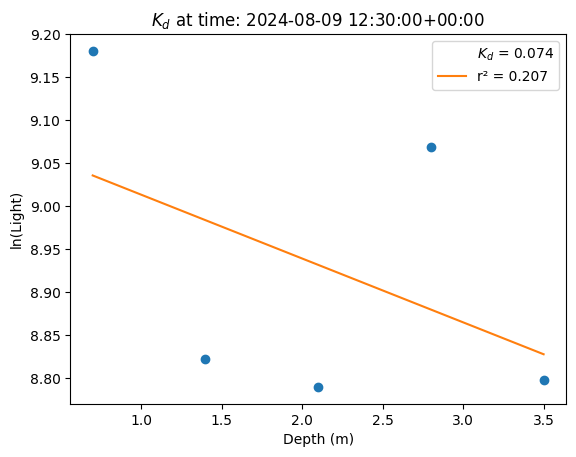

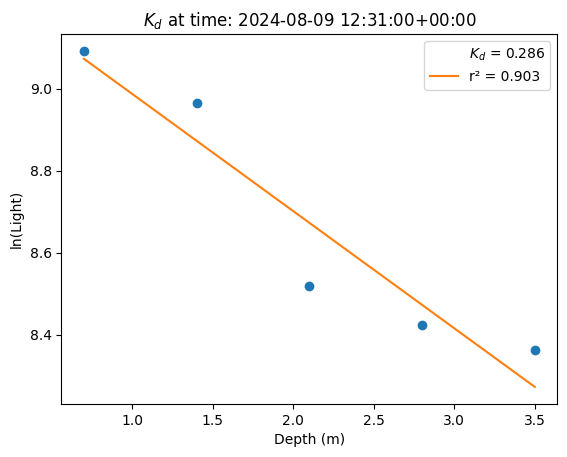

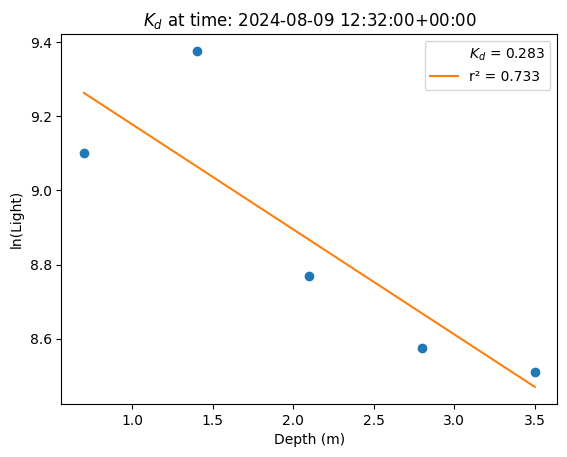

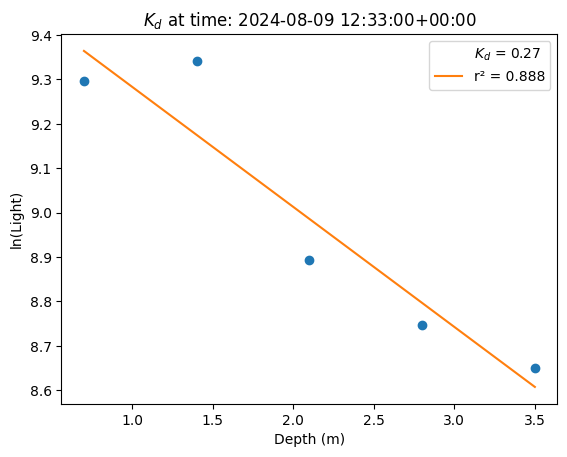

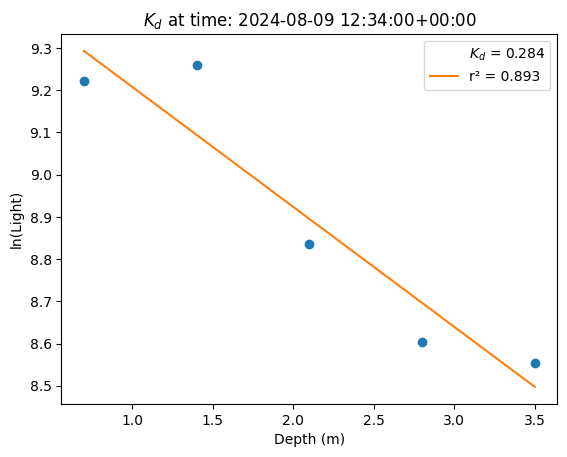

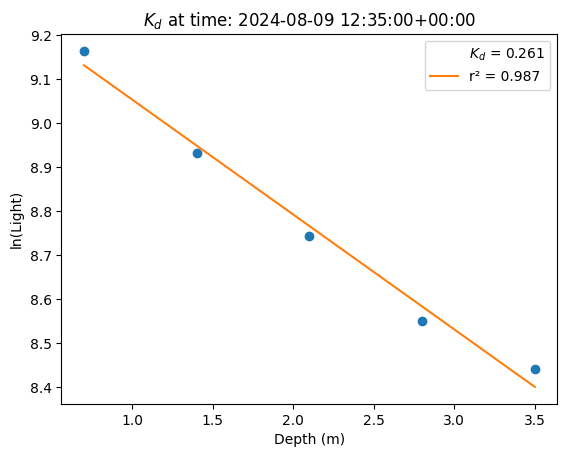

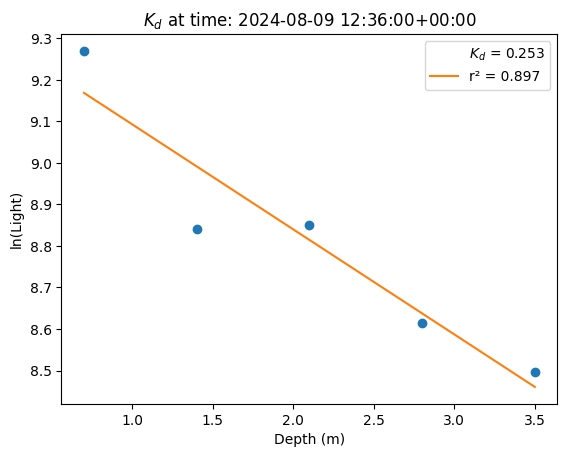

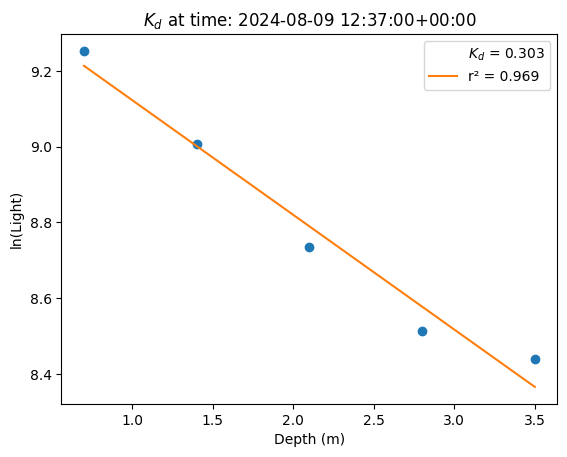

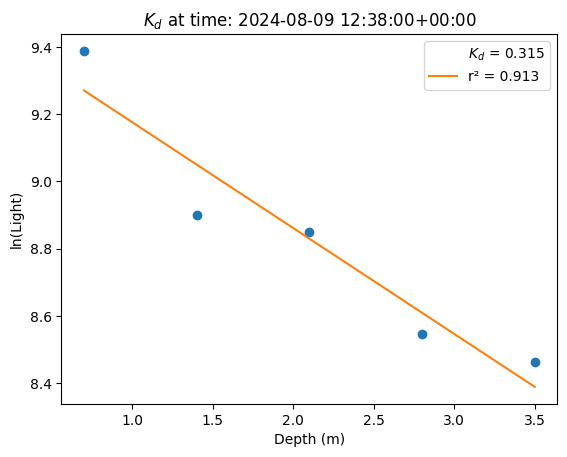

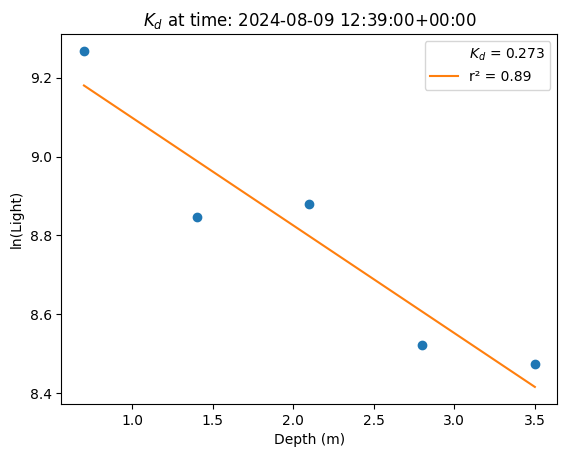

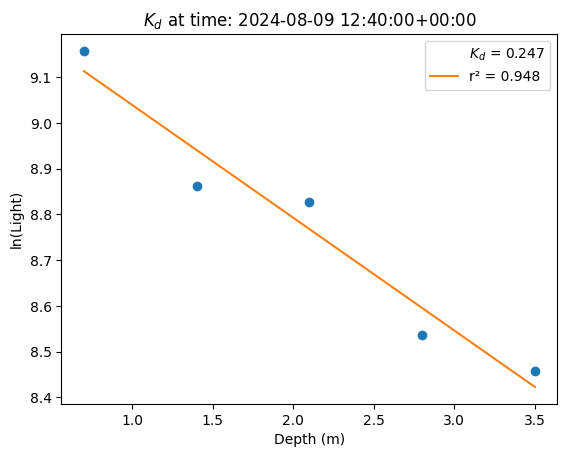

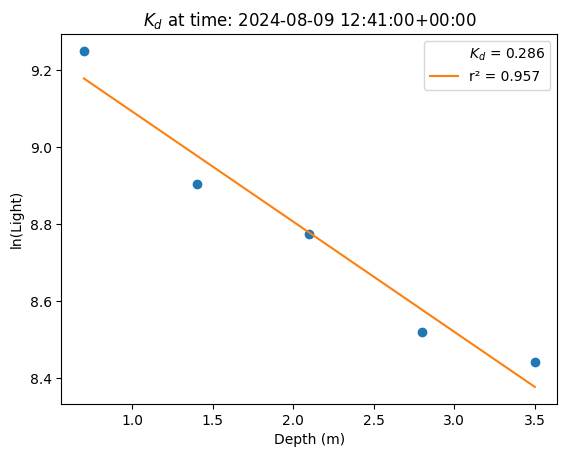

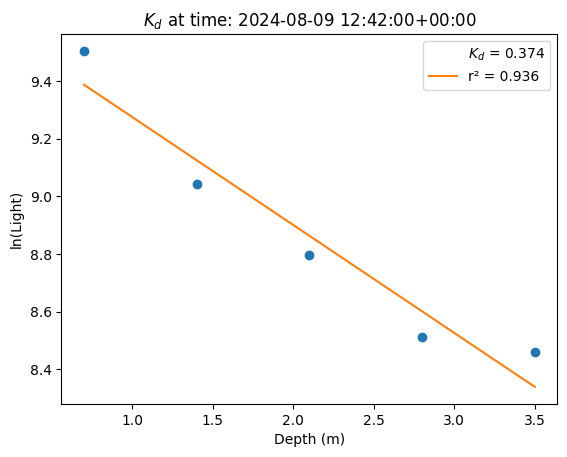

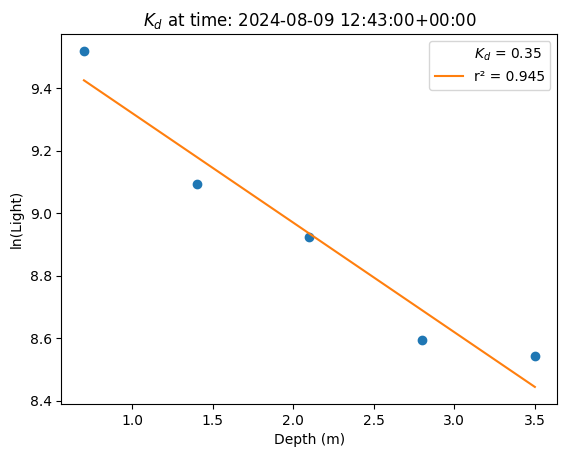

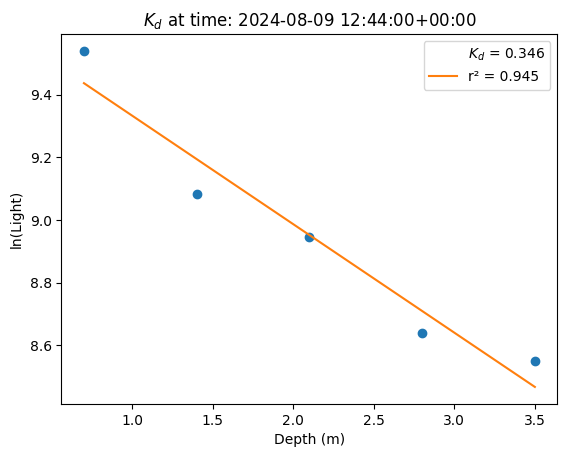

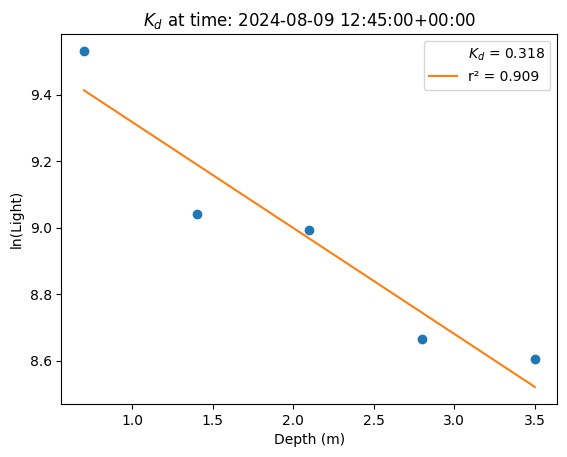

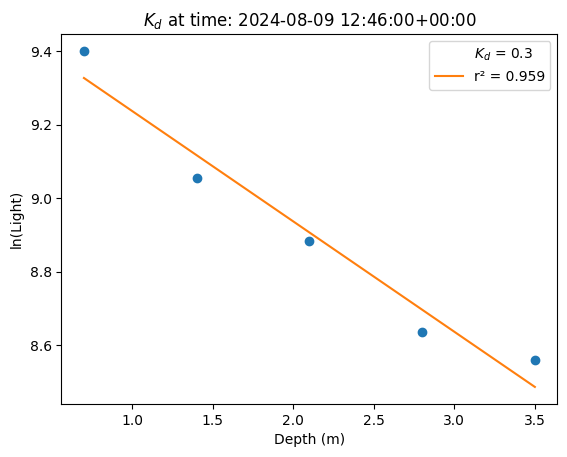

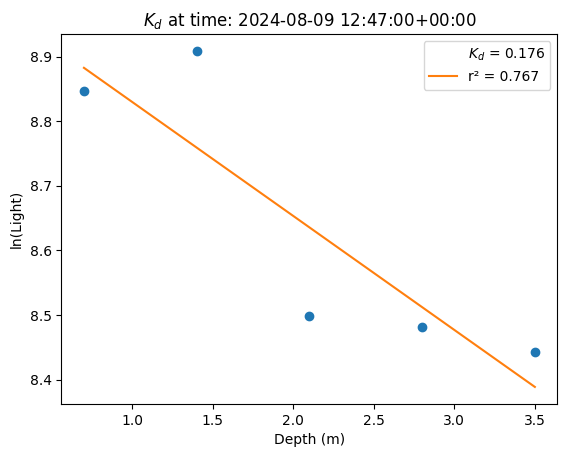

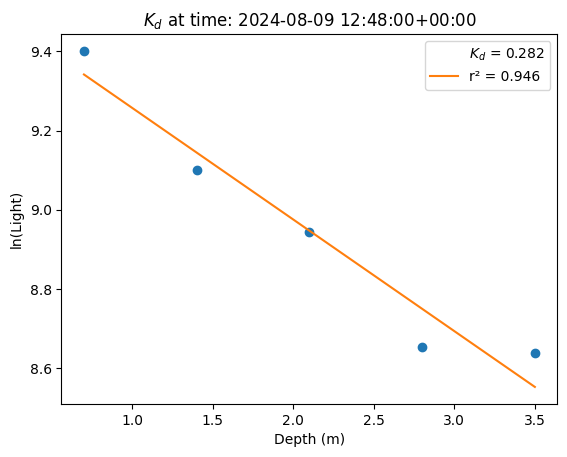

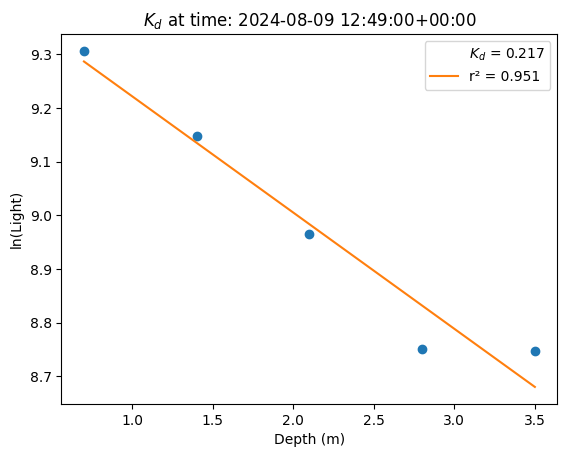

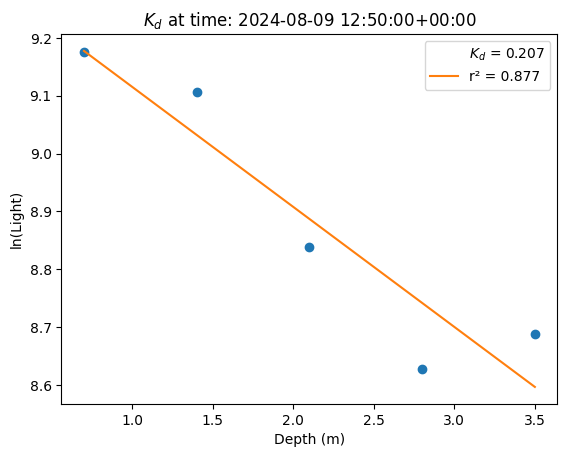

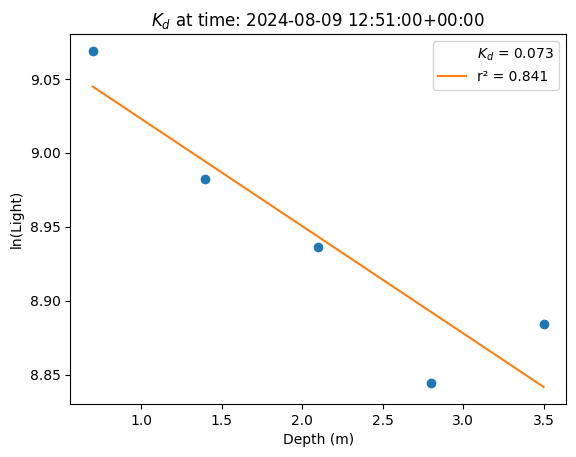

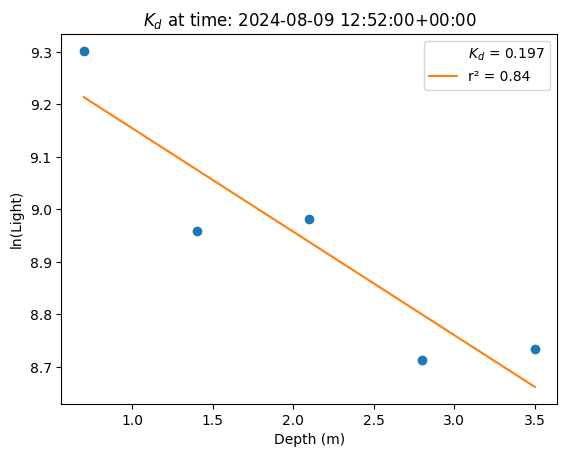

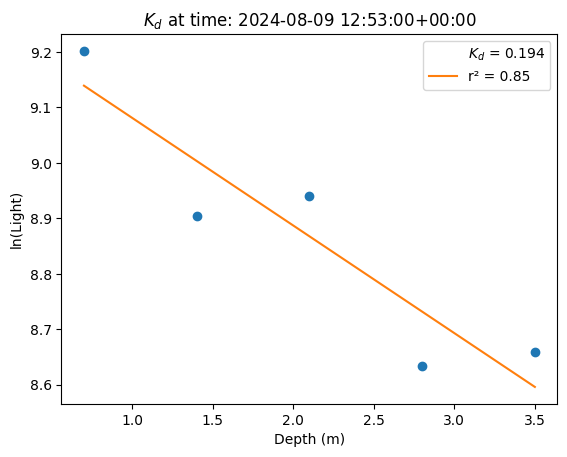

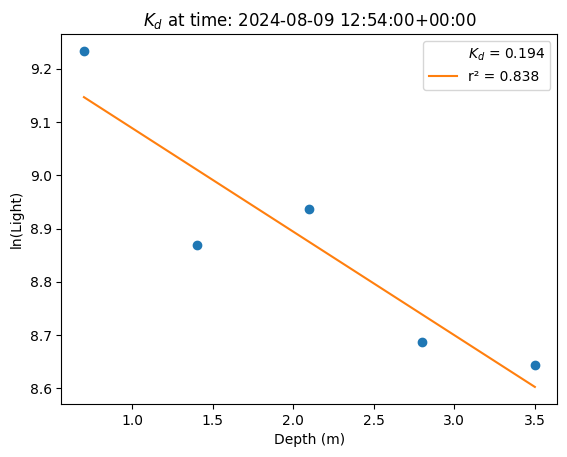

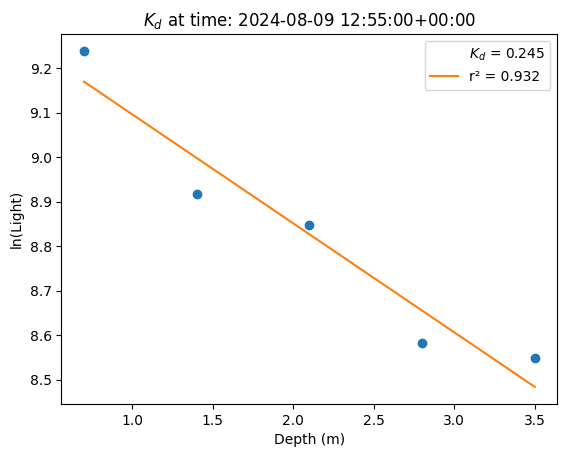

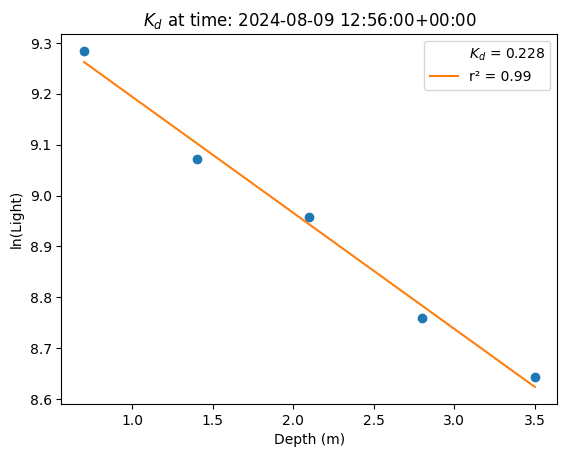

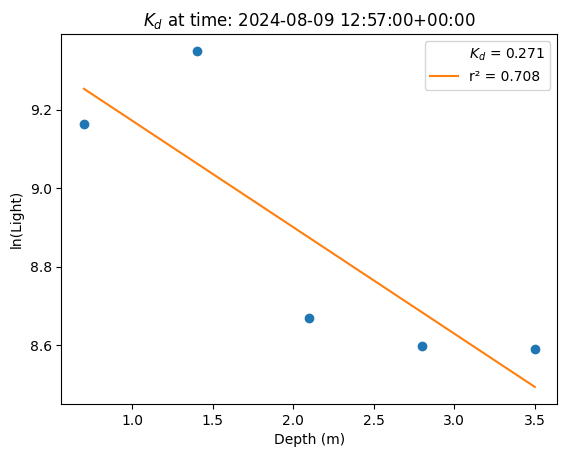

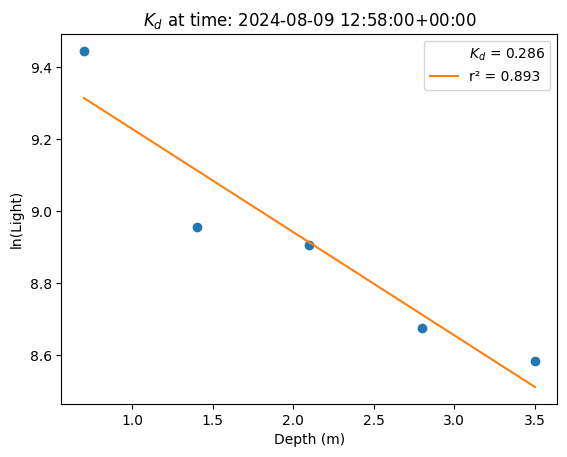

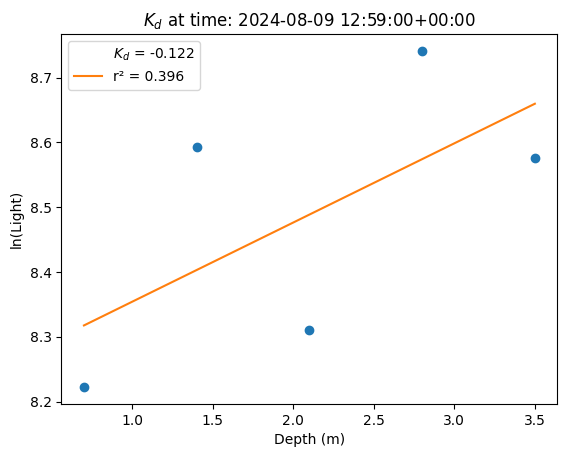

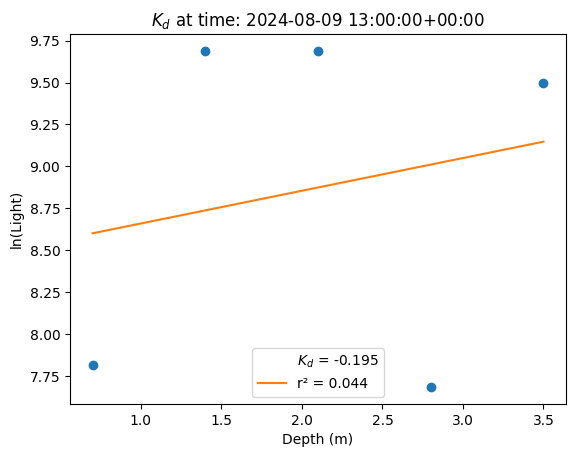

In [36]:
#@title 2.- Plot linear regressions for each minute (in the PAR band)

def plot_linear_regression():
  match_CLEAR = [s for s in wf_all.data if ("CLEAR_" in s) and ("QC" not in s)]
  # Iterate over each row of data
  for index, _row in wf_clear.data.iterrows():
  # CLEAR
    row_clear = wf_clear.data.loc[index, match_CLEAR].tolist()
    # calculate Kd from linear regression
    slope, _intercept, r_value, _p_value, _std_err = stats.linregress(depths,
                                                                      np.log(row_clear))

    depths_row_clear = np.array(depths)
    row_clear = np.array(np.log(row_clear))
    # plot depths - values clear
    plt.plot(depths_row_clear, row_clear, marker='o', linestyle="")
    plt.plot(depths_row_clear, slope*depths_row_clear + _intercept)
    plt.xlabel("Depth (m)")
    plt.ylabel("ln(Light)")
    plt.legend([f"$K_d$ = {np.around(slope * (-1), 3)}",
                f'r\N{SUPERSCRIPT TWO} = {np.around(r_value**2, 3)}'], loc='best', markerscale=0)
    plt.title(f"$K_d$ at time: {index}")
    plt.show()

  plt.close('all')

plot_linear_regression()



Plot Kd PAR time series


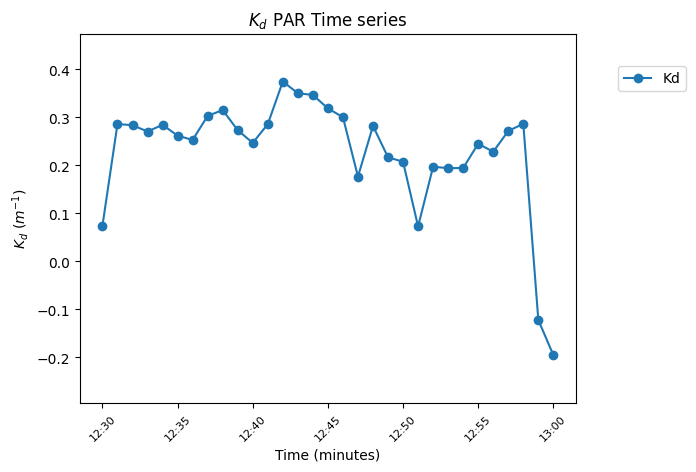



Plot Kd PAR with its coefficient of determination r2


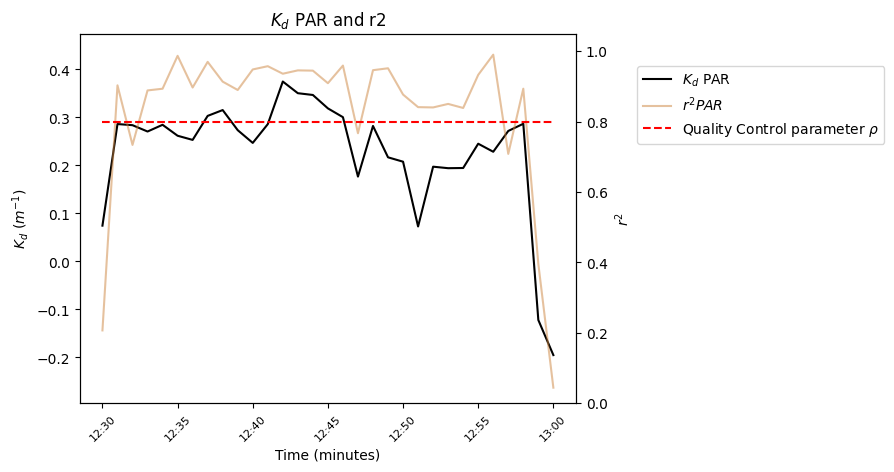




Plot Kd PAR with its coefficient of determination r2 applying Quality Control $\rho$


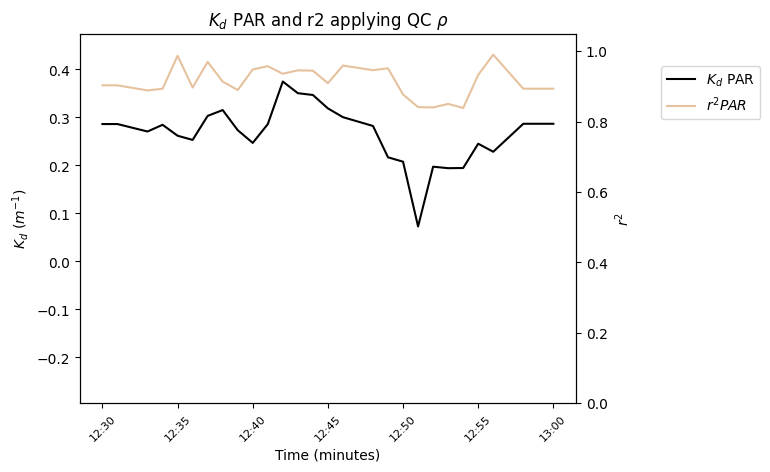



Plot Kd PAR, Kd Red, Kd Green and Kd Blue time series, with its coefficient of determination r2


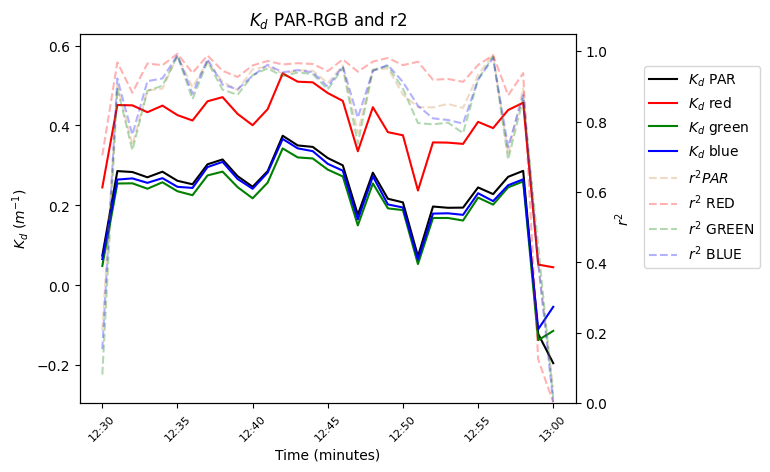

In [37]:
#@title 3.- Plot Kd Red, Green, Blue and PAR with r2 parameter

def plot_Kd():
  # Plot Kd
  print("\n\nPlot Kd PAR time series")
  fig, ax = plt.subplots()
  ax.set_ylabel('$K_d$ ($m^{-1}$)')
  ax.xaxis.set_tick_params(rotation=45)
  ax.tick_params(axis='x', labelsize=8)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
  plt.plot(wf_all.data['KD_CLEAR'], marker='o', linestyle="-")
  plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
  plt.xlabel("Time (minutes)")

  max_value = wf_all.data['KD_CLEAR'].max()
  min_value = wf_all.data['KD_CLEAR'].min()
  ax.set_ylim([min_value-0.1, max_value+0.1])

  ax.legend(["Kd"],
                            bbox_to_anchor=(1.25, 0.95),
                            borderaxespad=1.,
                            ncol=1,
                            fontsize=8,
                            title_fontsize=10,
                            prop={'size': 10}
                            )
  plt.title("$K_d$ PAR Time series")
  # plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
  plt.show()

  plt.close('all')

def plot_KdPAR_r2():
  # Plot Kd
  print("\n\nPlot Kd PAR with its coefficient of determination r2")
  wf_plot = md.WaterFrame()
  wf_plot.metadata = wf_all.metadata
  wf_plot.vocabulary = wf_all.vocabulary

  match_CLEAR = [s for s in wf_all.data if ("CLEAR" in s) and ("QC" not in s)]
  wf_plot.data[match_CLEAR] = wf_all.data.filter(match_CLEAR)

  wf_plot.data['R2_CLEAR_LEVEL'] = r2_value_input

  fig, ax = plt.subplots()
  twin1 = ax.twinx()
  twin1.set_ylabel('$r^2$')
  ax.set_ylabel('$K_d$ ($m^{-1}$)')
  ax.xaxis.set_tick_params(rotation=45)
  ax.tick_params(axis='x', labelsize=8)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

  p1, = ax.plot(wf_plot.data['KD_CLEAR'], color="black", linestyle='-',
                  label="$K_d$ PAR")

  p2, = twin1.plot(wf_plot.data['R2_CLEAR'], color="peru", linestyle='-', alpha=0.5, label="$r^2 PAR$")
  p3, = twin1.plot(wf_plot.data['R2_CLEAR_LEVEL'], color="red", linestyle='--', label=r"Quality Control parameter $\rho$")

  max_value = wf_all.data['KD_CLEAR'].max()
  min_value = wf_all.data['KD_CLEAR'].min()
  ax.set_ylim([min_value-0.1, max_value+0.1])
  twin1.set_ylim([0, 1.05])

  plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
  ax.legend(handles=[p1, p2, p3],
                            bbox_to_anchor=(1.65, 0.95),
                            borderaxespad=1.,
                            ncol=1,
                            fontsize=10,
                            title_fontsize=10,
                            prop={'size': 10}
                            )
  ax.set_xlabel("Time (minutes)")
  plt.title("$K_d$ PAR and r2")
  # plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
  plt.show()

  plt.close('all')

def plot_KdPAR_r2_interpolate():
  # Plot Kd
  print("\n\n")
  print(r"Plot Kd PAR with its coefficient of determination r2 applying Quality Control $\rho$")
  wf_plot = md.WaterFrame()
  wf_plot.metadata = wf_all.metadata
  wf_plot.vocabulary = wf_all.vocabulary

  match_CLEAR = [s for s in wf_all.data if ("CLEAR" in s) and ("QC" not in s)]
  wf_plot.data[match_CLEAR] = wf_all.data.filter(match_CLEAR)

  wf_plot.data = wf_plot.data.mask(wf_plot.data['R2_CLEAR'] < r2_value_input)
  wf_plot.data = wf_plot.data.interpolate(method='linear', axis=0).ffill().bfill()
  plt.close('all')
  fig, ax = plt.subplots()
  twin1 = ax.twinx()
  twin1.set_ylabel('$r^2$')
  ax.set_ylabel('$K_d$ ($m^{-1}$)')
  ax.xaxis.set_tick_params(rotation=45)
  ax.tick_params(axis='x', labelsize=8)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

  p1, = ax.plot(wf_plot.data['KD_CLEAR'], color="black", linestyle='-',
                  label="$K_d$ PAR")

  p2, = twin1.plot(wf_plot.data['R2_CLEAR'], color="peru", linestyle='-', alpha=0.5, label="$r^2 PAR$")

  max_value = wf_all.data['KD_CLEAR'].max()
  min_value = wf_all.data['KD_CLEAR'].min()
  ax.set_ylim([min_value-0.1, max_value+0.1])
  twin1.set_ylim([0, 1.05])

  plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
  ax.legend(handles=[p1, p2],
                            bbox_to_anchor=(1.40, 0.95),
                            borderaxespad=1.,
                            ncol=1,
                            fontsize=10,
                            title_fontsize=10,
                            prop={'size': 10}
                            )
  ax.set_xlabel("Time (minutes)")
  plt.title(r"$K_d$ PAR and r2 applying QC $\rho$")
  # plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
  plt.show()

  plt.close('all')

def plot_Kd_r2():
  # Plot Kd
  print("\n\nPlot Kd PAR, Kd Red, Kd Green and Kd Blue time series, with its coefficient of determination r2")
  plt.close('all')
  fig, ax = plt.subplots()
  twin1 = ax.twinx()
  twin1.set_ylabel('$r^2$')
  ax.set_ylabel('$K_d$ ($m^{-1}$)')
  ax.xaxis.set_tick_params(rotation=45)
  ax.tick_params(axis='x', labelsize=8)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

  p1, = ax.plot(wf_all.data['KD_CLEAR'], color="black", linestyle='-',
                  label="$K_d$ PAR")

  p1R, = ax.plot(wf_all.data['KD_RED'], color="red", linestyle='-',
                  label="$K_d$ red")

  p1G, = ax.plot(wf_all.data['KD_GREEN'], color="green", linestyle='-',
                  label="$K_d$ green")

  p1B, = ax.plot(wf_all.data['KD_BLUE'], color="blue", linestyle='-',
                  label="$K_d$ blue")

  p2, = twin1.plot(wf_all.data['R2_CLEAR'], color="peru", linestyle='--', alpha=0.3, label="$r^2 PAR$")
  p2R, = twin1.plot(wf_all.data['R2_RED'], color="red", linestyle='--', alpha=0.3, label="$r^2$ RED")
  p2G, = twin1.plot(wf_all.data['R2_GREEN'], color="green", linestyle='--', alpha=0.3, label="$r^2$ GREEN")
  p2B, = twin1.plot(wf_all.data['R2_BLUE'], color="blue", linestyle='--', alpha=0.3, label="$r^2$ BLUE")

  max_value = wf_all.data[['KD_CLEAR', 'KD_RED', 'KD_GREEN', 'KD_BLUE']].max().max()
  min_value = wf_all.data[['KD_CLEAR', 'KD_RED', 'KD_GREEN', 'KD_BLUE']].min().min()
  ax.set_ylim([min_value-0.1, max_value+0.1])
  twin1.set_ylim([0, 1.05])

  plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
  # ax.legend(handles=[p1, p1R, p1G, p1B, p2],
  ax.legend(handles=[p1, p1R, p1G, p1B, p2, p2R, p2G, p2B],
                            bbox_to_anchor=(1.40, 0.95),
                            borderaxespad=1.,
                            ncol=1,
                            fontsize=10,
                            title_fontsize=10,
                            prop={'size': 10}
                            )
  ax.set_xlabel("Time (minutes)")
  plt.title("$K_d$ PAR-RGB and r2")
  # plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
  plt.show()

  plt.close('all')

plot_Kd()

plot_KdPAR_r2()

plot_KdPAR_r2_interpolate()

plot_Kd_r2()